In [2]:
import time
import os 
import numpy as np
from scipy import sparse
import pandas as pd
import h5py
import anndata
import matplotlib.pyplot as plt
import seaborn as sns

from dredFISH.Utils.__init__plots import *
from dredFISH.Utils import basicu

In [3]:
ddir = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/'
res_dir = '/bigstore/GeneralStorage/fangming/projects/dredfish/res_dpnmf/'

In [4]:
%%time
# read in data
f = os.path.join(ddir, 'scrna_ss_ctxhippo_a_exon_count_matrix_v5.h5ad')
adata = anndata.read(f,
                     # backed='r',
                    )
adata

CPU times: user 1.07 s, sys: 14.9 s, total: 16 s
Wall time: 16 s


AnnData object with n_obs × n_vars = 73347 × 45768
    obs: 'donor_sex_id', 'donor_sex_label', 'donor_sex_color', 'region_id', 'region_label', 'region_color', 'platform_label', 'cluster_order', 'cluster_label', 'cluster_color', 'subclass_order', 'subclass_label', 'subclass_color', 'neighborhood_id', 'neighborhood_label', 'neighborhood_color', 'class_order', 'class_label', 'class_color', 'exp_component_name', 'external_donor_name_label', 'full_genotype_label', 'facs_population_plan_label', 'injection_roi_label', 'injection_materials_label', 'injection_method_label', 'injection_type_label', 'full_genotype_id', 'full_genotype_color', 'external_donor_name_id', 'external_donor_name_color', 'facs_population_plan_id', 'facs_population_plan_color', 'injection_materials_id', 'injection_materials_color', 'injection_method_id', 'injection_method_color', 'injection_roi_id', 'injection_roi_color', 'injection_type_id', 'injection_type_color', 'cell_type_accession_label', 'cell_type_alias_label', 'ce

In [5]:
cov = np.asarray(adata.X.sum(axis=1)).flatten()
medcov = np.median(cov)
covscale = cov/medcov
cov.shape

(73347,)

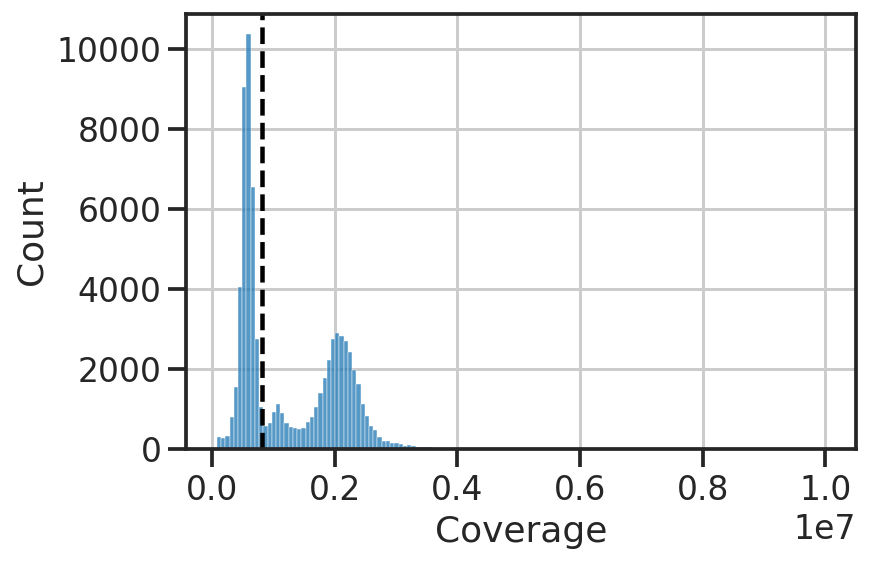

In [6]:
fig, ax = plt.subplots()
ax.set_xlabel('Coverage')
sns.histplot(cov, ax=ax)
ax.axvline(medcov, color='k', linestyle='--')
plt.show()

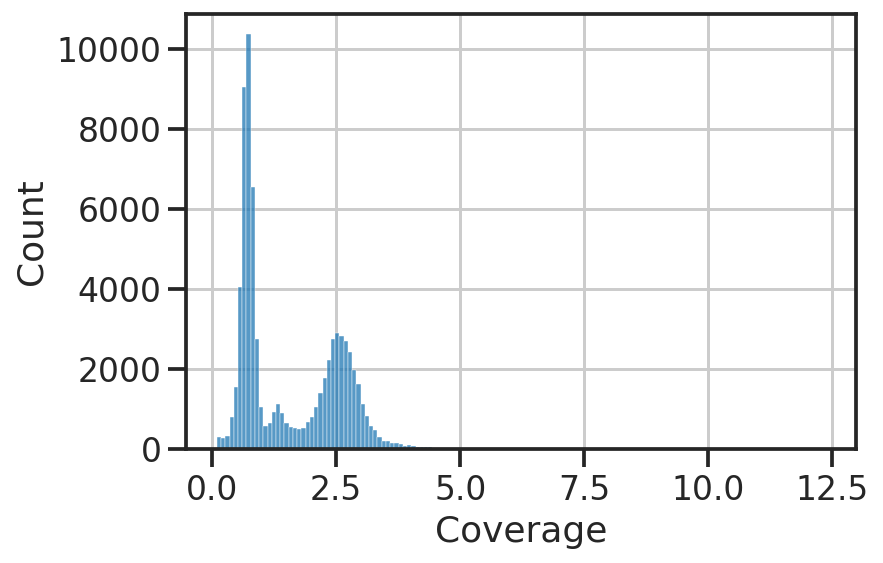

In [7]:
fig, ax = plt.subplots()
ax.set_xlabel('Coverage')
sns.histplot(covscale, ax=ax)
# ax.axvline(medcov, color='k', linestyle='--')
plt.show()

In [8]:
# get the NN genes
f = '/bigstore/binfo/mouse/Brain/DRedFISH/Allen_V3_Reference/10X/genes.npy' 
tenx_genes = np.load(f)
f = '/bigstore/binfo/mouse/Brain/DRedFISH/Allen_V3_Reference/SmartSeq/genes.npy' 
smrt_genes = np.load(f)
assert np.all(tenx_genes == smrt_genes)
nn_genes = tenx_genes
nn_genes.shape

(10861,)

# prep
- select relevant genes only
- subsample cells
- dense matrix
- numpy format
- library size norm

In [9]:
nn_genes_idx = basicu.get_index_from_array(adata.var.index.values, nn_genes)
(nn_genes_idx == -1).sum()

0

In [10]:
%%time
adata_nng = adata[:,adata.var.iloc[nn_genes_idx].index].copy()
adata_nng

CPU times: user 7.3 s, sys: 17.4 s, total: 24.7 s
Wall time: 24.8 s


AnnData object with n_obs × n_vars = 73347 × 10861
    obs: 'donor_sex_id', 'donor_sex_label', 'donor_sex_color', 'region_id', 'region_label', 'region_color', 'platform_label', 'cluster_order', 'cluster_label', 'cluster_color', 'subclass_order', 'subclass_label', 'subclass_color', 'neighborhood_id', 'neighborhood_label', 'neighborhood_color', 'class_order', 'class_label', 'class_color', 'exp_component_name', 'external_donor_name_label', 'full_genotype_label', 'facs_population_plan_label', 'injection_roi_label', 'injection_materials_label', 'injection_method_label', 'injection_type_label', 'full_genotype_id', 'full_genotype_color', 'external_donor_name_id', 'external_donor_name_color', 'facs_population_plan_id', 'facs_population_plan_color', 'injection_materials_id', 'injection_materials_color', 'injection_method_id', 'injection_method_color', 'injection_roi_id', 'injection_roi_color', 'injection_type_id', 'injection_type_color', 'cell_type_accession_label', 'cell_type_alias_label', 'ce

In [11]:
%%time
adata_nng.layers['norm'] = adata_nng.X.toarray()/covscale.reshape(-1,1)
adata_nng

CPU times: user 2.2 s, sys: 12.6 s, total: 14.8 s
Wall time: 14.8 s


AnnData object with n_obs × n_vars = 73347 × 10861
    obs: 'donor_sex_id', 'donor_sex_label', 'donor_sex_color', 'region_id', 'region_label', 'region_color', 'platform_label', 'cluster_order', 'cluster_label', 'cluster_color', 'subclass_order', 'subclass_label', 'subclass_color', 'neighborhood_id', 'neighborhood_label', 'neighborhood_color', 'class_order', 'class_label', 'class_color', 'exp_component_name', 'external_donor_name_label', 'full_genotype_label', 'facs_population_plan_label', 'injection_roi_label', 'injection_materials_label', 'injection_method_label', 'injection_type_label', 'full_genotype_id', 'full_genotype_color', 'external_donor_name_id', 'external_donor_name_color', 'facs_population_plan_id', 'facs_population_plan_color', 'injection_materials_id', 'injection_materials_color', 'injection_method_id', 'injection_method_color', 'injection_roi_id', 'injection_roi_color', 'injection_type_id', 'injection_type_color', 'cell_type_accession_label', 'cell_type_alias_label', 'ce

In [14]:
# preselect exc cell types only
print(adata_nng.obs['class_label'].unique())
adata_nng = adata_nng[adata_nng.obs['class_label']=='Glutamatergic']
adata_nng

['Glutamatergic']
Categories (1, object): ['Glutamatergic']


View of AnnData object with n_obs × n_vars = 48796 × 10861
    obs: 'donor_sex_id', 'donor_sex_label', 'donor_sex_color', 'region_id', 'region_label', 'region_color', 'platform_label', 'cluster_order', 'cluster_label', 'cluster_color', 'subclass_order', 'subclass_label', 'subclass_color', 'neighborhood_id', 'neighborhood_label', 'neighborhood_color', 'class_order', 'class_label', 'class_color', 'exp_component_name', 'external_donor_name_label', 'full_genotype_label', 'facs_population_plan_label', 'injection_roi_label', 'injection_materials_label', 'injection_method_label', 'injection_type_label', 'full_genotype_id', 'full_genotype_color', 'external_donor_name_id', 'external_donor_name_color', 'facs_population_plan_id', 'facs_population_plan_color', 'injection_materials_id', 'injection_materials_color', 'injection_method_id', 'injection_method_color', 'injection_roi_id', 'injection_roi_color', 'injection_type_id', 'injection_type_color', 'cell_type_accession_label', 'cell_type_alias_lab

In [15]:
# all cells
# randomly select cells L5 (allow oversample)
clstcol = 'cluster_label'
n = 100
dfsub, idxsub = basicu.stratified_sample_withrep(adata_nng.obs, clstcol, n, 
                                         return_idx=True, group_keys=False, sort=False, 
                                         random_state=0, 
                                        )

adatasub = adata_nng[adata_nng.obs.iloc[idxsub].index].copy()
adatasub

# randomly select cells L3 (does not allow oversamp)

/home/fangming/anaconda3/envs/torchgpu/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 23600 × 10861
    obs: 'donor_sex_id', 'donor_sex_label', 'donor_sex_color', 'region_id', 'region_label', 'region_color', 'platform_label', 'cluster_order', 'cluster_label', 'cluster_color', 'subclass_order', 'subclass_label', 'subclass_color', 'neighborhood_id', 'neighborhood_label', 'neighborhood_color', 'class_order', 'class_label', 'class_color', 'exp_component_name', 'external_donor_name_label', 'full_genotype_label', 'facs_population_plan_label', 'injection_roi_label', 'injection_materials_label', 'injection_method_label', 'injection_type_label', 'full_genotype_id', 'full_genotype_color', 'external_donor_name_id', 'external_donor_name_color', 'facs_population_plan_id', 'facs_population_plan_color', 'injection_materials_id', 'injection_materials_color', 'injection_method_id', 'injection_method_color', 'injection_roi_id', 'injection_roi_color', 'injection_type_id', 'injection_type_color', 'cell_type_accession_label', 'cell_type_alias_label', 'ce

In [16]:
adatasub.obs.groupby(clstcol).size()

cluster_label
1_CR             100
124_L2 IT APr    100
125_L2 IT APr    100
126_L2 IT APr    100
127_L2 IT APr    100
                ... 
360_CA2-IG-FC    100
361_DG           100
362_DG           100
363_DG           100
364_DG           100
Length: 236, dtype: int64

In [17]:
# convert to dense and format it; need the matrix and the labels

# X = adatasub.X.toarray().T # gene by cell
X = adatasub.layers['norm'].T # gene by cell
y = adatasub.obs[clstcol].values
X.shape, y.shape
y

['259_L5 PT CTX', '259_L5 PT CTX', '259_L5 PT CTX', '259_L5 PT CTX', '259_L5 PT CTX', ..., '262_L4 RSP-ACA', '262_L4 RSP-ACA', '262_L4 RSP-ACA', '262_L4 RSP-ACA', '262_L4 RSP-ACA']
Length: 23600
Categories (236, object): ['1_CR', '124_L2 IT APr', '125_L2 IT APr', '126_L2 IT APr', ..., '361_DG', '362_DG', '363_DG', '364_DG']

In [18]:
out_X = os.path.join(res_dir, 'test_X.npy') 
out_y = os.path.join(res_dir, 'test_y.npy') 
np.save(out_X, X)
np.save(out_y, y)

In [19]:
print(out_X)

/bigstore/GeneralStorage/fangming/projects/dredfish/res_dpnmf/test_X.npy
